In [ ]:
# run once only
import os
os.chdir("../")
print(os.getcwd())

In [2]:
import numpy as np
import tensorflow as tf
from avinoise import config, extraction, build_model, utils
import resampy.core as resampy

print(f"TF version: {tf.__version__}")

params = config.params()
params.summary()

TF version: 2.9.2

****************************Param summary****************************
	Name			|	Value
---------------------------------------------------------------------
	modif			|	2023-03-20 09:55:47.835116
	sr			|	16384
	mono			|	True
	audio_len		|	5
	n_mels			|	32
	n_fft			|	2048
	hop_length		|	256
	win_length		|	2048
	window			|	hann
	center			|	True
	pad_mode		|	reflect
	normalize		|	True
	cutoff			|	0.01
	data_root		|	./data
	augmentation_source	|	.\raw_data\augmentation_source
	raw_clean_path		|	.\raw_data\clean
	raw_contaminated_path	|	.\raw_data\contaminated
	model_type		|	2
	classes			|	['clean', 'contaminated']
	n_batches		|	64
	n_epochs		|	10
	metrics			|	['Precision', 'Recall', 'CategoricalAccuracy']
	tensorboard		|	True
	verbose			|	False
	n_frames		|	321
*********************************************************************



In [7]:
train_path = os.path.join(params.data_root, "train")
test_path = os.path.join(params.data_root, "test")
if input("Do you want to extract features? (y/n)") == "y":
    io_spec = extraction.saveFeatures(train_path, test_path)

In [8]:
loaded_train, loaded_test = extraction.loadFeatures(train_path, test_path)

In [9]:
model = build_model.build_model(params.model_type, loaded_train.element_spec[0].shape[1:], 
                                loaded_train.element_spec[1].shape[1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 319, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 159, 32)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 159, 32)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 157, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 78, 64)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 78, 64)        

In [10]:
!kill 3400
%load_ext tensorboard
%tensorboard --logdir .
# http://localhost:6006/

hist = model.fit(loaded_train,
                 validation_data=loaded_test,
                 callbacks=[utils.tensorboard()],
                 epochs=params.n_epochs)

/bin/bash: line 0: kill: (3400) - No such process


Epoch 1/10
1301/1301 [==============================] - 710s 544ms/step - loss: 0.3836 - precision: 0.8322 - recall: 0.8322 - categorical_accuracy: 0.8322 - val_loss: 0.3491 - val_precision: 0.8661 - val_recall: 0.8661 - val_categorical_accuracy: 0.8661
Epoch 2/10
1301/1301 [==============================] - 697s 536ms/step - loss: 0.2810 - precision: 0.8864 - recall: 0.8864 - categorical_accuracy: 0.8864 - val_loss: 0.2976 - val_precision: 0.8853 - val_recall: 0.8853 - val_categorical_accuracy: 0.8853
Epoch 3/10
1301/1301 [==============================] - 699s 537ms/step - loss: 0.2532 - precision: 0.8996 - recall: 0.8996 - categorical_accuracy: 0.8996 - val_loss: 0.3124 - val_precision: 0.8794 - val_recall: 0.8794 - val_categorical_accuracy: 0.8794
Epoch 4/10
1301/1301 [==============================] - 697s 536ms/step - loss: 0.2246 - precision: 0.9109 - recall: 0.9109 - categorical_accuracy: 0.9109 - val_loss: 0.2965 - val_precision: 0.8993 - val_recall: 0.8993 - val_categorical_a

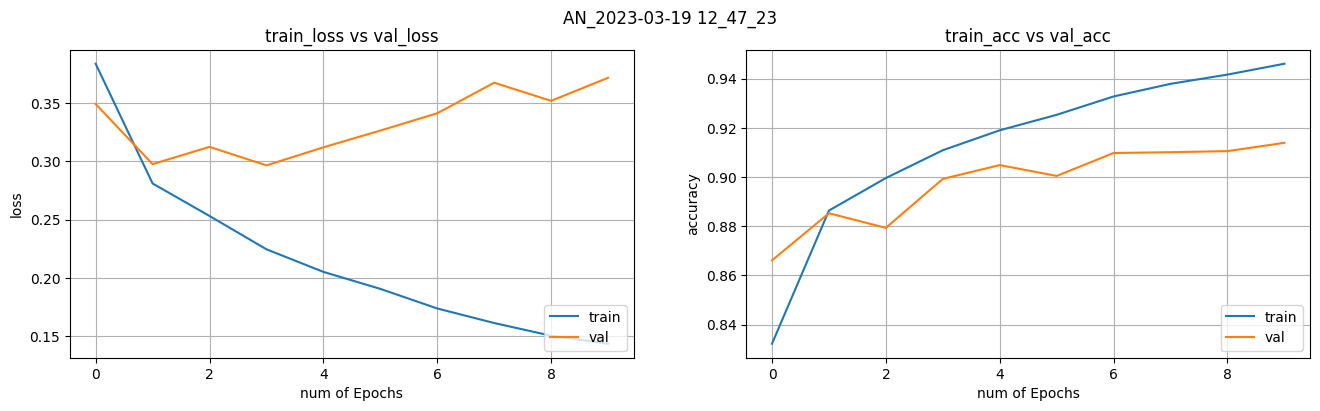

In [11]:
utils.plotMetrics(hist)

In [12]:
from sklearn.metrics import classification_report

y_test_prob = model.predict(loaded_test)
y_test_pred = np.argmax(y_test_prob, axis=1)
y_test_true = np.argmax(np.array([y for x, y in loaded_test.unbatch().as_numpy_iterator()]), 
                        axis=1)

print('Classification report:')
print(classification_report(y_true=y_test_true, y_pred=y_test_pred, target_names=params.classes))

567/567 [==============================] - 64s 112ms/step
Classification report:
              precision    recall  f1-score   support

       clean       0.89      0.94      0.92     18144
contaminated       0.94      0.88      0.91     18144

    accuracy                           0.91     36288
   macro avg       0.92      0.91      0.91     36288
weighted avg       0.92      0.91      0.91     36288



In [14]:
os.makedirs("_models", exist_ok=True)
model.save(os.path.join("_models", utils.genModelName()))
model.save_weights(os.path.join("_models", utils.genWeightsName()))
utils.dict2README(os.path.join("_models", utils._genTimestampName() + "md"))